In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os,shutil
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
classes = []
for i in os.listdir('/content/drive/MyDrive/nirscene1'):
  classes.append(i)
print(classes)

['mountain', 'country', 'oldbuilding', 'indoor', 'street', 'field', 'forest', 'urban', 'water']


In [6]:
for c in classes:
  os.makedirs(os.path.join('/content/drive/MyDrive/rgb_images'+'/'+c))
  os.makedirs(os.path.join('/content/drive/MyDrive/nir_images'+'/'+c))

In [11]:
# Function to segregate rgb and nir data into different directories.

def split_images(path,label):
  nir_path_destination = "/content/drive/MyDrive/nir_images/"+label
  rgb_path_destination = "/content/drive/MyDrive/rgb_images/"+label
  nir_images = []
  rgb_images = []
  for i in os.listdir(path):
    if '_nir' in i:
      nir_images.append(i)
    else:
      rgb_images.append(i)
  

  for n in nir_images:
    shutil.move(path+'/'+n,nir_path_destination)
  
  for r in rgb_images:
    shutil.move(path+'/'+r,rgb_path_destination)

In [12]:
for c in classes:
  split_images('/content/drive/MyDrive/nirscene1'+'/'+c,c)

In [21]:
#tiff to jpg converter
def tiff2jpg():
  nir_path = '/content/drive/MyDrive/nir_images/'
  rgb_path = '/content/drive/MyDrive/rgb_images/'
  for label in classes:
    for image in os.listdir(nir_path+label):
      im = Image.open(nir_path+'{}/{}'.format(label,image))
      im.save(nir_path+'{}/{}.jpg'.format(label,image))
      os.remove(nir_path+'{}/{}'.format(label,image))
    for image in os.listdir(rgb_path+label):
      im = Image.open(rgb_path+'{}/{}'.format(label,image))
      im.save(rgb_path+'{}/{}.jpg'.format(label,image))
      os.remove(rgb_path+'{}/{}'.format(label,image))
      
tiff2jpg()


In [24]:
# Pre process data
data_dir_rgb = "/content/drive/MyDrive/rgb_images"
data_dir_nir = "/content/drive/MyDrive/nir_images"

img_height = 128
img_width = 128
batch_size = 32

train_rgb_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_rgb,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_rgb_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_rgb,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_nir_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_nir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_nir_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_nir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 477 files belonging to 9 classes.
Using 382 files for training.
Found 477 files belonging to 9 classes.
Using 95 files for validation.
Found 477 files belonging to 9 classes.
Using 382 files for training.
Found 477 files belonging to 9 classes.
Using 95 files for validation.


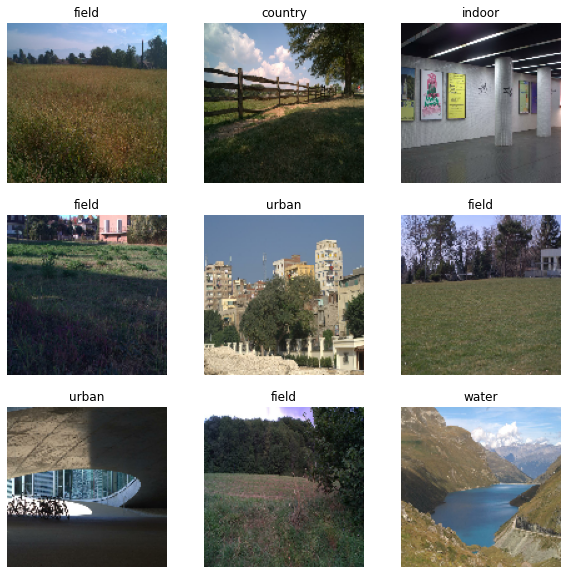

In [28]:
# Visualization of the RGB Dataset

class_names = train_rgb_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_rgb_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

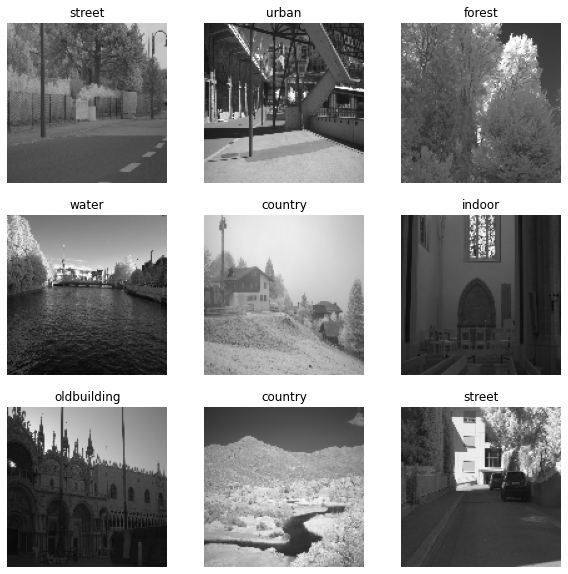

In [29]:
# Visualization of the NIR Dataset

class_names = train_nir_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_nir_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

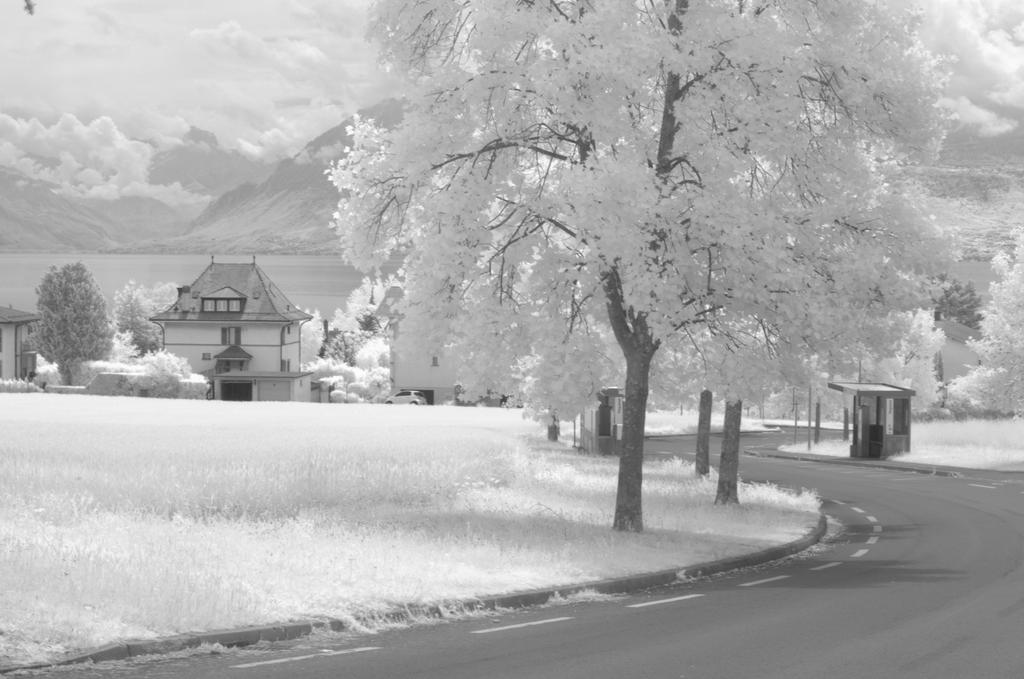

In [18]:


def create_convolution_layers(input_img):
  num_classes = 9

  model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
  ])
    
  return model




# model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
#   model = LeakyReLU(alpha=0.1)(model)
#   model = MaxPooling2D((2, 2),padding='same')(model)
#   model = Dropout(0.25)(model)
  
#   model = Conv2D(64, (3, 3), padding='same')(model)
#   model = LeakyReLU(alpha=0.1)(model)
#   model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
#   model = Dropout(0.25)(model)
    
#   model = Conv2D(128, (3, 3), padding='same')(model)
#   model = LeakyReLU(alpha=0.1)(model)
#   model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
#   model = Dropout(0.4)(model)

In [23]:
train_ds.class_names

['country',
 'field',
 'forest',
 'indoor',
 'mountain',
 'oldbuilding',
 'street',
 'urban',
 'water']